In [14]:
import os
import tqdm
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
import xgboost
import catboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import joblib
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, LinearLR, MultiStepLR

## Data analysis and preprocessing

In [3]:
def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> pd.DataFrame:
    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('train')])
    print(dataset_paths)

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        chunk = pd.read_parquet(chunk_path,columns=columns)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)


def create_dataset(path):
    for i, elem in enumerate(['df_'+str(a) for a in range(0, 12)]):
        elem = read_parquet_dataset_from_local(path, i, 1)
        if i==0:
            df = elem.copy()
        else:
            df = pd.concat([df, elem], ignore_index=True, axis=0)
        del elem
    return df

In [4]:
pd.options.display.max_columns = None

In [ ]:
path = 'train_data/'
df = create_dataset(path)

In [15]:
df.shape

(26162717, 61)

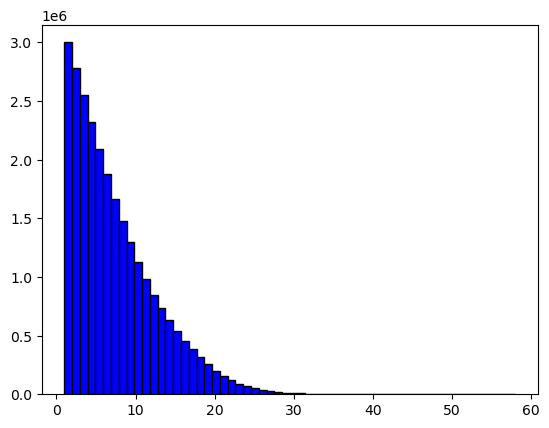

In [32]:
#распределение кредитный продуктов по клиентам
plt.hist(df['rn'], color = 'blue', edgecolor = 'black', bins = int(df['rn'].nunique()));

In [9]:
cat_columns = ['pre_since_opened', 'pre_since_confirmed', 'pre_pterm',
       'pre_fterm', 'pre_till_pclose', 'pre_till_fclose',
       'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
       'pre_loans_outstanding', 'pre_loans_total_overdue',
       'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5',
       'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90', 
        'pre_util', 'pre_over2limit', 'pre_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2',
       'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7',
       'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12',
       'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16',
       'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20',
       'enc_paym_21', 'enc_paym_22', 'enc_paym_23', 'enc_paym_24',
       'enc_loans_account_holder_type', 'enc_loans_credit_status',
       'enc_loans_credit_type', 'enc_loans_account_cur']

In [10]:
df.isna().sum()
#пропусков нет

id                         0
rn                         0
pre_since_opened           0
pre_since_confirmed        0
pre_pterm                  0
                          ..
enc_loans_credit_status    0
enc_loans_credit_type      0
enc_loans_account_cur      0
pclose_flag                0
fclose_flag                0
Length: 61, dtype: int64

In [33]:
targets = pd.read_csv('train_target.csv')
targets

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2999995,2999995,0
2999996,2999996,0
2999997,2999997,0
2999998,2999998,0


так как часть данных бинаризована имеет смысл провести кодирование с последующей группировкой + данные по длине совпадут с таргетом

In [ ]:
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore', dtype='int8')
df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
df.drop(columns=cat_columns, inplace=True)

In [37]:
df.shape

(26162717, 362)

In [38]:
#новый признак
df_1 = df.iloc[:, :2].copy().groupby(['id']).max()
df_1.columns = ['max_rn']

In [ ]:
df = df.groupby(['id']).sum()
df.merge(df_1, how='left', on='id').drop(columns='rn')
df.loc[:, 'target'] = targets.loc[:, 'flag']

In [40]:
int_64_cols  = df.select_dtypes('int64').columns
df[int_64_cols] = df[int_64_cols].astype('int8')

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000000 entries, 0 to 2999999
Columns: 362 entries, rn to target
dtypes: int8(362)
memory usage: 1.0 GB


In [42]:
df['target'].value_counts()

target
0    2893558
1     106442
Name: count, dtype: int64

In [43]:
df['target'].value_counts()[1]/df['target'].value_counts()[0]

0.03678585326438938

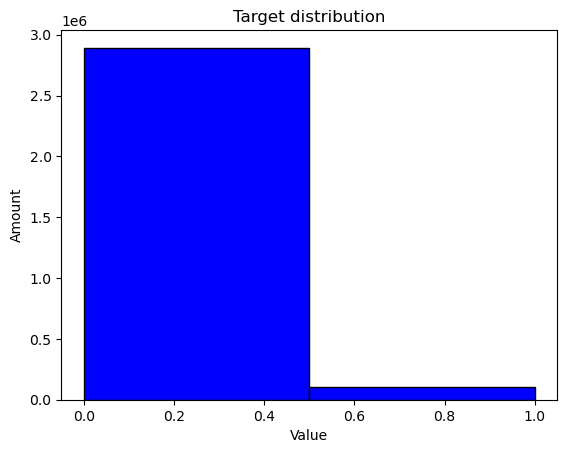

In [48]:
plt.hist(df['target'], color = 'blue', edgecolor = 'black', bins = int(df['target'].nunique()))
plt.title('Target distribution')
plt.xlabel('Value')
plt.ylabel('Amount');

## Modeling

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df['target'], stratify=df['target'], train_size=0.7)

### Random Forest

In [15]:
%%time
rf = RandomForestClassifier(n_estimators=15,
                           max_depth=9,
                           min_samples_leaf=8).fit(X_train, y_train)

print('train: ', roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]))
print('test: ', roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

train:  0.7300298634541145
test:  0.7195067107844934
CPU times: total: 59.6 s
Wall time: 59.8 s


In [ ]:
%%time
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 20, 40)
    max_depth = trial.suggest_int('max_depth', 5, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',  2, 15)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    score = cross_val_score(model, X_train, y_train, cv=2, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_score = study.best_value

In [20]:
best_params

{'n_estimators': 33, 'max_depth': 10, 'min_samples_leaf': 14}

In [25]:
%%time
rf = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                           max_depth=best_params['max_depth'],
                           min_samples_leaf=best_params['min_samples_leaf']).fit(X_train, y_train)

print('train: ', roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]))
print('test: ', roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

train:  0.7435445833965082
test:  0.7284031662748849
CPU times: total: 2min 16s
Wall time: 2min 16s


In [35]:
imp_df = pd.DataFrame({'features': X_train.columns.tolist(), 'imp': rf.feature_importances_.tolist()})
new_columns = imp_df.loc[imp_df['imp']!=0, 'features']

In [37]:
%%time
rf = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                           max_depth=best_params['max_depth'],
                           min_samples_leaf=best_params['min_samples_leaf']).fit(X_train[new_columns], y_train)

print('train: ', roc_auc_score(y_train, rf.predict_proba(X_train[new_columns])[:,1]))
print('test: ', roc_auc_score(y_test, rf.predict_proba(X_test[new_columns])[:,1]))

train:  0.7423180453915181
test:  0.7264555741531732
CPU times: total: 2min 10s
Wall time: 2min 10s


In [ ]:
%%time
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 20, 100)
    max_depth = trial.suggest_int('max_depth', 5, 11)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',  2, 31)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    score = cross_val_score(model, X_train[new_columns], y_train, cv=2, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)

best_params = study.best_params
best_score = study.best_value

In [41]:
%%time
rf = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                           max_depth=best_params['max_depth'],
                           min_samples_leaf=best_params['min_samples_leaf']).fit(X_train, y_train)

print('train: ', roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]))
print('test: ', roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

train:  0.7542475988164754
test:  0.7324634480010748
CPU times: total: 7min 51s
Wall time: 7min 53s


### XGBoost

In [5]:
%%time
model = xgboost.XGBClassifier(
    n_estimators=350,
    objective='binary:logistic',
    max_depth=10,
    learning_rate=0.05,
    eval_metric='auc',
    early_stopping_rounds=10
)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=10)

[0]	validation_0-auc:0.71161	validation_1-auc:0.70195
[10]	validation_0-auc:0.73547	validation_1-auc:0.72135
[20]	validation_0-auc:0.74660	validation_1-auc:0.72781
[30]	validation_0-auc:0.76035	validation_1-auc:0.73324
[40]	validation_0-auc:0.77237	validation_1-auc:0.73815
[50]	validation_0-auc:0.78398	validation_1-auc:0.74251
[60]	validation_0-auc:0.79339	validation_1-auc:0.74554
[70]	validation_0-auc:0.80181	validation_1-auc:0.74823
[80]	validation_0-auc:0.80941	validation_1-auc:0.75005
[90]	validation_0-auc:0.81582	validation_1-auc:0.75161
[100]	validation_0-auc:0.82144	validation_1-auc:0.75294
[110]	validation_0-auc:0.82651	validation_1-auc:0.75386
[120]	validation_0-auc:0.83110	validation_1-auc:0.75472
[130]	validation_0-auc:0.83484	validation_1-auc:0.75529
[140]	validation_0-auc:0.83869	validation_1-auc:0.75573
[150]	validation_0-auc:0.84231	validation_1-auc:0.75611
[160]	validation_0-auc:0.84549	validation_1-auc:0.75644
[170]	validation_0-auc:0.84832	validation_1-auc:0.75679
[18

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=350, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [6]:
imp_df = pd.DataFrame({'features': X_train.columns.tolist(), 'imp': model.feature_importances_.tolist()})
new_columns = imp_df.loc[imp_df['imp']!=0, 'features']

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 150, 300, step=10)
    max_depth = trial.suggest_int('max_depth', 5, 11)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.5, 1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.01, 1)
    colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.01, 1)
    colsample_bynode = trial.suggest_float('colsample_bynode', 0.01, 1)
    

    model = xgboost.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, 
                                  subsample=subsample, colsample_bytree=colsample_bytree, colsample_bylevel=colsample_bylevel,
                                  colsample_bynode=colsample_bynode, objective='binary:logistic', 
                                  eval_metric='auc', early_stopping_rounds=10).fit(X_train[new_columns], y_train, 
                                  eval_set=[(X_train[new_columns], y_train), (X_test[new_columns], y_test)], verbose=10)
    metric = model.evals_result()['validation_1']['auc'][-1]
    
    return metric

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_params = study.best_params
best_score = study.best_value

In [9]:
%%time
model = xgboost.XGBClassifier(
    n_estimators=350,
    objective='binary:logistic',
    max_depth=10,
    learning_rate=0.047,
    subsample=0.9268,
    colsample_bytree=0.7107,
    colsample_bylevel=0.8465,
    colsample_bynode=0.4592,
    eval_metric='auc',
    early_stopping_rounds=10
)
model.fit(X_train[new_columns], y_train, eval_set=[(X_train[new_columns], y_train), (X_test[new_columns], y_test)], verbose=10)

[0]	validation_0-auc:0.68944	validation_1-auc:0.67947
[10]	validation_0-auc:0.74558	validation_1-auc:0.72982
[20]	validation_0-auc:0.75246	validation_1-auc:0.73360
[30]	validation_0-auc:0.76233	validation_1-auc:0.73783
[40]	validation_0-auc:0.77015	validation_1-auc:0.74088
[50]	validation_0-auc:0.77798	validation_1-auc:0.74360
[60]	validation_0-auc:0.78524	validation_1-auc:0.74582
[70]	validation_0-auc:0.79241	validation_1-auc:0.74801
[80]	validation_0-auc:0.79854	validation_1-auc:0.74990
[90]	validation_0-auc:0.80395	validation_1-auc:0.75143
[100]	validation_0-auc:0.80898	validation_1-auc:0.75267
[110]	validation_0-auc:0.81413	validation_1-auc:0.75389
[120]	validation_0-auc:0.81846	validation_1-auc:0.75464
[130]	validation_0-auc:0.82218	validation_1-auc:0.75545
[140]	validation_0-auc:0.82596	validation_1-auc:0.75622
[150]	validation_0-auc:0.82918	validation_1-auc:0.75681
[160]	validation_0-auc:0.83211	validation_1-auc:0.75712
[170]	validation_0-auc:0.83482	validation_1-auc:0.75751
[18

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.8465, colsample_bynode=0.4592,
              colsample_bytree=0.7107, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.047, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=350, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Catboost

In [43]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, learning_rate=0.3, eval_metric='AUC',
                                             early_stopping_rounds=20, verbose=20, random_seed=42)
boosting_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=20, plot=True)

print('train: ', roc_auc_score(y_train, boosting_model.predict_proba(X_train)[:, 1]))
print('test: ', roc_auc_score(y_test, boosting_model.predict_proba(X_test)[:, 1]))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5136239	best: 0.5136239 (0)	total: 316ms	remaining: 1m 2s
20:	test: 0.7268109	best: 0.7268109 (20)	total: 11s	remaining: 1m 34s
40:	test: 0.7377880	best: 0.7377880 (40)	total: 21.7s	remaining: 1m 24s
60:	test: 0.7429433	best: 0.7429433 (60)	total: 32.5s	remaining: 1m 14s
80:	test: 0.7452983	best: 0.7452983 (80)	total: 42.8s	remaining: 1m 2s
100:	test: 0.7465679	best: 0.7465679 (100)	total: 52.6s	remaining: 51.6s
120:	test: 0.7474535	best: 0.7474535 (120)	total: 1m 2s	remaining: 40.7s
140:	test: 0.7483265	best: 0.7483265 (140)	total: 1m 11s	remaining: 30.1s
160:	test: 0.7487045	best: 0.7487069 (158)	total: 1m 21s	remaining: 19.7s
180:	test: 0.7490716	best: 0.7490716 (180)	total: 1m 30s	remaining: 9.5s
199:	test: 0.7493597	best: 0.7493773 (197)	total: 1m 40s	remaining: 0us

bestTest = 0.7493772559
bestIteration = 197

Shrink model to first 198 iterations.
train:  0.7578590434922184
test:  0.7493772559287459


### Grid

In [ ]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, learning_rate=0.3, eval_metric='AUC',
                                             early_stopping_rounds=20, verbose=20, random_seed=42)

params = {'depth': np.arange(4, 8, 1), 'learning_rate': np.arange(0.1, 0.5, 0.1), 'min_data_in_leaf': np.arange(3, 5, 1)}

boosting_model.grid_search(params, X_train, y_train, cv=3, search_by_train_test_split=True, calc_cv_statistics=True,
                           plot=True, refit=True, stratified=True) 

In [135]:
best_params = boosting_model.get_all_params()
best_params

{'nan_mode': 'Min',
 'eval_metric': 'AUC',
 'iterations': 200,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'od_wait': 20,
 'class_names': [0, 1],
 'random_seed': 42,
 'depth': 7,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model

In [5]:
boosting_model_2 = catboost.CatBoostClassifier(n_estimators=500, learning_rate=0.3, eval_metric='AUC',
                                             early_stopping_rounds=20, verbose=20, random_seed=42,
                                            depth=7, min_data_in_leaf=3)

boosting_model_2.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=50, plot=True)

print('train: ', roc_auc_score(y_train, boosting_model_2.predict_proba(X_train)[:, 1]))
print('test: ', roc_auc_score(y_test, boosting_model_2.predict_proba(X_test)[:, 1]))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5403323	best: 0.5403323 (0)	total: 449ms	remaining: 3m 44s
50:	test: 0.7406433	best: 0.7406433 (50)	total: 22.4s	remaining: 3m 17s
100:	test: 0.7458627	best: 0.7458772 (99)	total: 43.7s	remaining: 2m 52s
150:	test: 0.7473500	best: 0.7473639 (149)	total: 1m 4s	remaining: 2m 29s
200:	test: 0.7481973	best: 0.7482015 (199)	total: 1m 25s	remaining: 2m 7s
250:	test: 0.7485814	best: 0.7485814 (250)	total: 1m 47s	remaining: 1m 46s
300:	test: 0.7489793	best: 0.7489793 (300)	total: 2m 12s	remaining: 1m 27s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7491580894
bestIteration = 308

Shrink model to first 309 iterations.
train:  0.7693149192237118
test:  0.7491580893562763


In [7]:
boosting_model_2.get_feature_importance(prettified=True)

,Feature Id,Importances
0,pre_util_3,8.154100
1,is_zero_loans530,7.547831
2,pre_loans_credit_limit_2,6.612090
3,pre_util_6,5.342999
4,enc_paym_22_3,4.650208
...,...,...
190,pre_loans3060_6,0.000000
191,pre_loans3060_9,0.000000
192,pre_loans6090_3,0.000000
193,pre_over2limit_18,0.000000


In [8]:
df_imp = pd.DataFrame(boosting_model_2.get_feature_importance(prettified=True))

In [9]:
len(df_imp.loc[df_imp['Importances']>0]['Feature Id'].tolist())

175

In [10]:
#убираю лишние фичи
df_imp = pd.DataFrame(boosting_model_2.get_feature_importance(prettified=True))
new_cols = df_imp.loc[df_imp['Importances']>0]['Feature Id'].tolist()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df[new_cols], df['target'], stratify=df['target'], train_size=0.7)
X_train.shape

(2001418, 175)

In [12]:
boosting_model_2 = catboost.CatBoostClassifier(n_estimators=500, learning_rate=0.3, eval_metric='AUC',
                                             early_stopping_rounds=20, verbose=20, random_seed=42,
                                            depth=7, min_data_in_leaf=3)

boosting_model_2.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=50, plot=True)

print('train: ', roc_auc_score(y_train, boosting_model_2.predict_proba(X_train)[:, 1]))
print('test: ', roc_auc_score(y_test, boosting_model_2.predict_proba(X_test)[:, 1]))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5947286	best: 0.5947286 (0)	total: 345ms	remaining: 2m 52s
50:	test: 0.7426050	best: 0.7426050 (50)	total: 21s	remaining: 3m 4s
100:	test: 0.7477287	best: 0.7477287 (100)	total: 40.5s	remaining: 2m 39s
150:	test: 0.7498418	best: 0.7498418 (150)	total: 1m	remaining: 2m 18s
200:	test: 0.7507420	best: 0.7507819 (198)	total: 1m 19s	remaining: 1m 58s
250:	test: 0.7513661	best: 0.7513809 (249)	total: 1m 38s	remaining: 1m 37s
300:	test: 0.7518082	best: 0.7518316 (299)	total: 1m 57s	remaining: 1m 17s
350:	test: 0.7521967	best: 0.7522053 (349)	total: 2m 17s	remaining: 58.4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7522874505
bestIteration = 357

Shrink model to first 358 iterations.
train:  0.7709935366016526
test:  0.7522874505188494


### Neural network

In [54]:
from tqdm.auto import tqdm

X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df['target'], stratify=df['target'], 
                                                    train_size=0.7, random_state=1)


X_train_t =  torch.FloatTensor(X_train.values)
y_train_t =  torch.FloatTensor(y_train.values).view(-1, 1)
X_test_t =  torch.FloatTensor(X_test.values)
y_test_t =  torch.FloatTensor(y_test.values).view(-1, 1)

train_loader = torch.utils.data.DataLoader(list(zip(X_train_t, y_train_t)), batch_size=10000, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(X_test_t, y_test_t)), batch_size=10000, shuffle=False)

import torch.nn.functional as F
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()        
        self.fc1 = nn.Linear(361, 216, bias=True)
        self.fc2 = nn.Linear(216, 130, bias=True)
        self.dropout = nn.Dropout(p=0.4)
        self.fc3 = nn.Linear(130, 78, bias=True)
        self.fc4 = nn.Linear(78, 39, bias=True)
        self.fc5 = nn.Linear(39, 1, bias=True)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.sigmoid(self.fc5(x))
        return x

nn_model = Net()

def train_stochastic(model, loader, criterion, optimazer, num_epoch, X_train_t, y_train_t):
    
    losses = []
    roc_auc_metrics = []
    for t in tqdm(range(num_epoch)):
        epoch_loss = []
        metrics = []
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            epoch_loss.append(loss.item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
                     
        losses.append(np.mean(epoch_loss))
        print("curr_loss", np.mean(epoch_loss))
        
        with torch.no_grad():
            nn_prediction_train = model(X_train_t).tolist()
            roc_auc_metrics.append(roc_auc_score(y_train_t, nn_prediction_train))
            print('train: ', roc_auc_score(y_train_t, nn_prediction_train))

    return model, losses, roc_auc_metrics
    
loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-3)

model, losses, metrics = train_stochastic(nn_model, train_loader, loss, optimizer, 15, X_train_t, y_train_t)



with torch.no_grad():
    nn_prediction_train = model(X_train_t)
    nn_prediction_train = nn_prediction_train.tolist() 
    
    nn_prediction_test = model(X_test_t)
    nn_prediction_test = nn_prediction_test.tolist()

    print('train: ', roc_auc_score(y_train, nn_prediction_train))
    print('test: ', roc_auc_score(y_test, nn_prediction_test))

  0%|          | 0/15 [00:00<?, ?it/s]

curr_loss 0.1836996316200211
train:  0.7304729559196442
curr_loss 0.1411219557126363
train:  0.7460666199059471
curr_loss 0.13972157956588835
train:  0.7513843278067072
curr_loss 0.13877129334779012
train:  0.7570041933580814
curr_loss 0.13819176458886692
train:  0.7608164091577205
curr_loss 0.1378076552989937
train:  0.7627375672049768
curr_loss 0.1374118372797966
train:  0.7656595506650496
curr_loss 0.13705579155967348
train:  0.7690076909951372
curr_loss 0.13685141099350792
train:  0.7686768545830803
curr_loss 0.1365907577176889
train:  0.7713685655896559
curr_loss 0.13625181246371496
train:  0.774605643066052
curr_loss 0.13589044099762326
train:  0.7757127840407803
curr_loss 0.13552879478250232
train:  0.77796611830665
curr_loss 0.13521782124326343
train:  0.7794071986940345
curr_loss 0.13482717013075238
train:  0.7825171128905027
train:  0.7825188101411484
test:  0.7527168482160213


In [55]:
def plot_trainig(losses, metrics):
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel("epoch")
    plt.plot(losses, label="train_loss")
    #plt.plot(valid_losses, label="valid_loss")
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.xlabel("epoch")
    plt.plot(metrics, label="train_roc-auc")
    plt.legend()

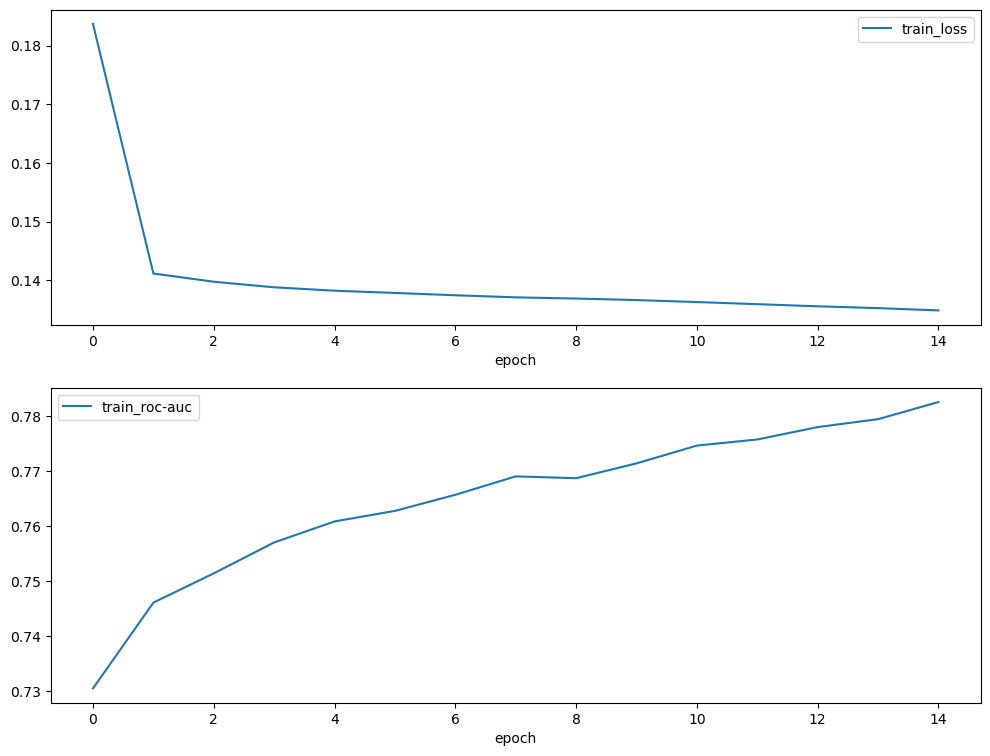

In [56]:
plot_trainig(losses, metrics)